# Link:
https://github.com/XinyuLiu71/CSE830-Homework/blob/main/3/Q6/main.ipynb

# 1. Hypothesis
Building upon the results from Q5, which demonstrated that Insertion Sort is more efficient for small input sizes (`n`), this experiment aims to create a hybrid sorting algorithm. **This algorithm will use Merge Sort as its primary strategy for dividing the problem, but will switch to Insertion Sort for partitions smaller than or equal to a specific threshold, `k`.**

My hypotheses:

The resulting hybrid algorithm will be faster than a pure Merge Sort implementation across a wide range of input sizes. This is because the hybrid approach will avoid the relatively high overhead of Merge Sort's deep recursion on very small arrays, leveraging Insertion Sort's low-overhead performance in those specific cases.

The optimal value for the threshold `k` will be related to the crossover point found in Q5 ($n ≈ 64$), but likely not identical. I suspect the optimal `k` might be smaller than the crossover point. The reasoning is that the decision to switch is not just about the sorting time of an isolated partition, but also about the cost of continuing the recursion (e.g., function calls, array slicing). The algorithm may achieve better overall performance by switching to Insertion Sort earlier to avoid these cumulative overhead costs.

# 2. Methods
The experiment was conducted in two main phases: 
first, finding the optimal threshold `k`, and second, comparing the optimized hybrid algorithm against the original pure implementations.

Algorithm Implementation:
A `hybrid_sort(arr, k)` function was implemented. It mirrors the recursive structure of `merge_sort` but modifies the base case: if the length of a partition is less than or equal to `k`, it calls `insertion_sort` on that partition; otherwise, it continues with the recursive Merge Sort logic. The implementations of `insertion_sort` and `merge_sort` from Q5 were reused.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import sys

sys.setrecursionlimit(2000)

# --- Reuse my functions from Q5 ---
def insertion_sort(arr):
    """Sorts an array in place using the insertion sort algorithm."""
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0 and key < arr[j]:
            arr[j + 1] = arr[j]
            j -= 1
        arr[j + 1] = key
    return arr

def merge_sort(arr):
    """Sorts an array using the merge sort algorithm."""
    if len(arr) > 1:
        mid = len(arr) // 2
        left_half = arr[:mid]
        right_half = arr[mid:]

        merge_sort(left_half)
        merge_sort(right_half)

        i = j = k = 0
        while i < len(left_half) and j < len(right_half):
            if left_half[i] < right_half[j]:
                arr[k] = left_half[i]
                i += 1
            else:
                arr[k] = right_half[j]
                j += 1
            k += 1

        while i < len(left_half):
            arr[k] = left_half[i]
            i += 1
            k += 1

        while j < len(right_half):
            arr[k] = right_half[j]
            j += 1
            k += 1
    return arr

# --- Q6: New Hybrid Sort Implementation ---
def hybrid_sort_recursive(arr, k):
    """
    Recursive helper for hybrid sort.
    Sorts an array using merge sort, but switches to insertion sort
    for partitions of size <= k.
    """
    if len(arr) <= k:
        insertion_sort(arr)
    elif len(arr) > 1:
        mid = len(arr) // 2
        left_half = arr[:mid]
        right_half = arr[mid:]

        hybrid_sort_recursive(left_half, k)
        hybrid_sort_recursive(right_half, k)

        i = j = l = 0 
        while i < len(left_half) and j < len(right_half):
            if left_half[i] < right_half[j]:
                arr[l] = left_half[i]
                i += 1
            else:
                arr[l] = right_half[j]
                j += 1
            l += 1

        while i < len(left_half):
            arr[l] = left_half[i]
            i += 1
            l += 1

        while j < len(right_half):
            arr[l] = right_half[j]
            j += 1
            l += 1
    return arr

def hybrid_sort(arr, k):
    return hybrid_sort_recursive(arr, k)

## Experiment 1: Finding the Optimal k
Goal: determine the value of `k` that minimizes the execution time of the hybrid sort.

Input: The tests were run on large, fixed-size arrays of random integers (`n = 5000` and `n = 10000`) to ensure the algorithm performed enough recursive splits for `k` to have a meaningful impact.

Parameter Range: from k=2 to k=128.

Timing Methodology: For each (n, k) pair, the `hybrid_sort` function was timed using Python's `timeit` module over 50 repetitions to obtain a stable average execution time.

Starting Experiment 1: Finding the optimal k...
Testing for array size n = 5000...
Testing for array size n = 10000...
Experiment 1 complete.
For n=5000, optimal k is 38 with time 0.005018s
For n=10000, optimal k is 18 with time 0.011276s

Chosen optimal k for next experiment: k = 28


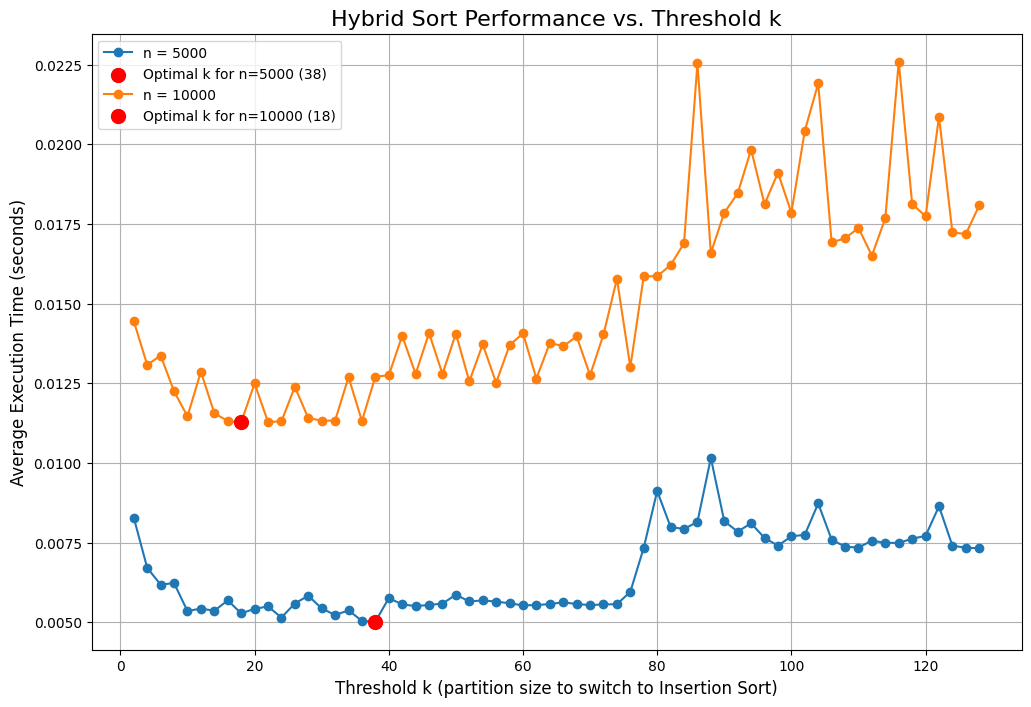

In [ ]:
print("Starting Experiment 1: Finding the optimal k...")

test_n_values = [5000, 10000] 

# Test a wide range of k values, bracketing the Q5 crossover point of ~64
k_values = np.arange(2, 129, 2)

k_timing_results = {n: [] for n in test_n_values}
num_repeats_k_search = 50 

rng = np.random.default_rng(42) 

for n in test_n_values:
    print(f"Testing for array size n = {n}...")
    for k in k_values:
        setup_code = f"""
import numpy as np
from __main__ import hybrid_sort
rng = np.random.default_rng(42)
data = rng.integers(0, 50000, {n}).tolist()
"""
        
        stmt_code = f"hybrid_sort(data.copy(), k={k})"
        
        time = timeit.timeit(stmt=stmt_code, setup=setup_code, number=num_repeats_k_search)
        k_timing_results[n].append(time / num_repeats_k_search)

print("Experiment 1 complete.")

# ===================================================================
# Results (Part 1): Plotting to Find Optimal k
# ===================================================================

fig, ax = plt.subplots(figsize=(12, 8))
optimal_k_values = []

for n in test_n_values:
    times = k_timing_results[n]
    ax.plot(k_values, times, 'o-', label=f'n = {n}')
    
    # Find and annotate the minimum time
    min_time = min(times)
    optimal_k = k_values[times.index(min_time)]
    optimal_k_values.append(optimal_k)
    print(f"For n={n}, optimal k is {optimal_k} with time {min_time:.6f}s")
    ax.scatter([optimal_k], [min_time], color='red', s=100, zorder=5, label=f'Optimal k for n={n} ({optimal_k})')

# We'll choose one k value for the final comparison. The average is a good choice.
k_optimal = int(np.mean(optimal_k_values))
print(f"\nChosen optimal k for next experiment: k = {k_optimal}")

ax.set_title('Hybrid Sort Performance vs. Threshold k', fontsize=16)
ax.set_xlabel('Threshold k (partition size to switch to Insertion Sort)', fontsize=12)
ax.set_ylabel(f'Average Execution Time (seconds)', fontsize=12)
ax.legend()
ax.grid(True)
plt.show()

## Results 1:
As shown in the graph, the performance is best when k is relatively small. For an input size of `n=5000`, the optimal threshold was `k=38`. For `n=10000`, the optimal `k` was 18. Based on these results, an average value of `k=28` was selected for the final comparison.

## Experiment 2: Final Performance Comparison
Goal: compared the performance of the optimized hybrid algorithm against the original Insertion Sort and Merge Sort.

Algorithm Setup: The hybrid sort was configured to use the optimal threshold determined in Experiment 1, which was `k=28` (the average of the best-performing values for n=5000 and n=10000).

Input: The three algorithms were tested on random integer arrays with sizes `n` ranging from 2 to 500, matching the range from the Q5 experiment for direct comparison.

Timing Methodology: The timeit module was used again, with 500 repetitions for each `n` to ensure high-precision results.

Starting Experiment 2: Comparing all three algorithms using k=28...
Experiment 2 complete.


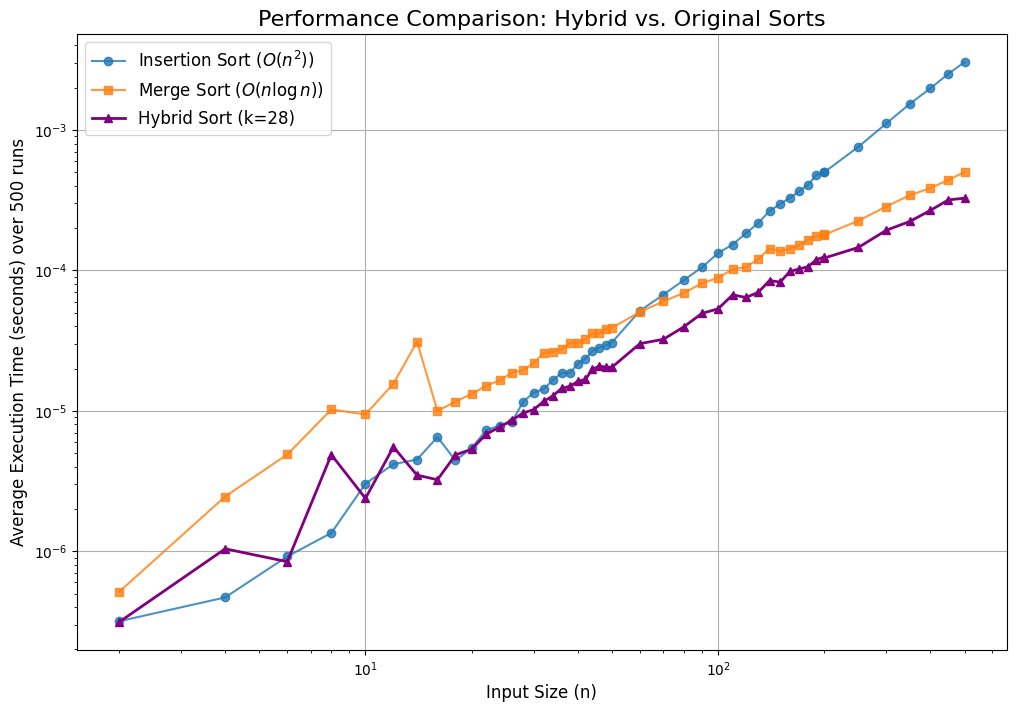

In [ ]:
print(f"Starting Experiment 2: Comparing all three algorithms using k={k_optimal}...")

# Use the same n_values as in your Q5 for a direct comparison
n_values_small = np.arange(2, 50, 2)
n_values_medium = np.arange(50, 201, 10)
n_values_large = np.arange(200, 501, 50)
n_values = np.concatenate([n_values_small, n_values_medium, n_values_large])

insertion_times_final = []
merge_times_final = []
hybrid_times_final = []

num_repeats_final = 500 # Use the same number of repeats as Q5

for n in n_values:
    setup_code = f"""
import numpy as np
from __main__ import insertion_sort, merge_sort, hybrid_sort
rng = np.random.default_rng(42)
data = rng.integers(0, 1000, {int(n)}).tolist()
"""
    
    # Time Insertion Sort
    is_time = timeit.timeit(stmt="insertion_sort(data.copy())", setup=setup_code, number=num_repeats_final)
    insertion_times_final.append(is_time / num_repeats_final)
    
    # Time Merge Sort
    ms_time = timeit.timeit(stmt="merge_sort(data.copy())", setup=setup_code, number=num_repeats_final)
    merge_times_final.append(ms_time / num_repeats_final)

    # Time Hybrid Sort with optimal k
    hs_time = timeit.timeit(stmt=f"hybrid_sort(data.copy(), k={k_optimal})", setup=setup_code, number=num_repeats_final)
    hybrid_times_final.append(hs_time / num_repeats_final)
    
print("Experiment 2 complete.")


# ===================================================================
# Results (Part 2): Final Comparison Plot
# ===================================================================
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(n_values, insertion_times_final, 'o-', label='Insertion Sort ($O(n^2)$)', alpha=0.8)
ax.plot(n_values, merge_times_final, 's-', label='Merge Sort ($O(n \\log n)$)', alpha=0.8)
ax.plot(n_values, hybrid_times_final, '^-', label=f'Hybrid Sort (k={k_optimal})', color='purple', linewidth=2)


ax.set_title('Performance Comparison: Hybrid vs. Original Sorts', fontsize=16)
ax.set_xlabel('Input Size (n)', fontsize=12)
ax.set_ylabel(f'Average Execution Time (seconds) over {num_repeats_final} runs', fontsize=12)
ax.legend(fontsize=12)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True)
plt.show()

## Results 2:
The graph illustrates the performance of Insertion Sort (blue), Merge Sort (orange), and the Hybrid Sort with `k=28` (purple). For `n <= 28`, the Hybrid Sort's performance is identical to Insertion Sort. For `n > 28`, the Hybrid Sort's performance curve runs parallel to but consistently below the Merge Sort curve, indicating a clear performance improvement.

# 4. Discussion
From experimental results show, the hybrid algorithm demonstrated a consistent performance advantage over the pure Merge Sort for n greater than the chosen threshold `k`.

The most surprising result was that the optimal `k` (found to be between 18 and 38) was significantly lower than the direct performance crossover point observed in Q5 (`n ≈ 64`). I think it's because the decision context matters. In the hybrid algorithm, the choice is not simply between which sort is faster for a given sub-array, but whether the cost of an additional recursive step (including function call overhead and array slicing in Python) is worth it. The data suggests that it is more efficient for the system to switch to the low-overhead Insertion Sort earlier than the Q5 crossover point would imply, thus avoiding the cumulative costs of deep recursion.

The final comparison graph shows hybrid algorithm effectively creates a new performance envelope that tracks the best of both algorithms across the entire range of tested inputs. The implementation successfully combined the low-overhead advantage of Insertion Sort for small partitions with the superior asymptotic complexity of Merge Sort for the overall structure.

# 5. Conclusions
This experiment successfully demonstrated the value of a hybrid sorting strategy.

Under the tested conditions, a hybrid algorithm that uses Merge Sort for large partitions and switches to Insertion Sort for partitions of size `k` offers a measurable performance improvement over a pure Merge Sort. The optimal threshold was experimentally determined to be `k ≈ 28`, a value substantially smaller than the direct performance crossover point between the two algorithms.

The final conclusion is that the hybrid sort is the superior algorithm across the entire range of tested inputs, which leverages the distinct strengths of two classic sorting methods.